In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
import pydicom
from tqdm import tqdm
from PIL import Image
from pathlib import Path
import torch
import albumentations as A

In [2]:
def window_image(image, window_center, window_width): #윈도윙 해주기
  img_min = window_center - window_width // 2
  img_max = window_center + window_width // 2
  window_image = image.copy()
  window_image[window_image < img_min] = img_min
  window_image[window_image > img_max] = img_max
  return window_image

In [3]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value) 
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars\n
        torch.backends.cudnn.deterministic = True  #needed\n
        torch.backends.cudnn.benchmark = False
        
seed = 42
random_seed(seed,True)

In [4]:
wl, ww = 112,384
random_windowing = True
submission_name = 'submission_fastai3.csv'

## Make Training Data

In [5]:
def path_list(root_dir, mode, valid_num, positive_only = False):
    path_images = []
    path_labels = []
    if mode == "train":
        for patient in tqdm(sorted(os.listdir(os.path.join(root_dir, "train/DICOM")))):
            if 'training' in patient and patient.split('g')[-1] not in valid_num:
                for z_slice in sorted(os.listdir(os.path.join(root_dir, "train/DICOM", patient))):
                    if z_slice.split('.')[-1] == "dcm":
                        name = z_slice.split('.')[0]
                        path_image = os.path.join(root_dir, "train/DICOM", patient, f"{name}.dcm")
                        path_label = os.path.join(root_dir, "train/Label", patient, f"{name}.png")
                        if positive_only:
                            temp_label = cv2.imread(path_label)
                            if np.all(temp_label == 0):
                                continue
                            else:
                                path_images.append(path_image)
                                path_labels.append(path_label)
                        else:
                            path_images.append(path_image)
                            path_labels.append(path_label)
#                         path_images.append(path_image)
#                         path_labels.append(path_label)
                            
                
    else:
        for patient in tqdm(sorted(os.listdir(os.path.join(root_dir, "train/DICOM")))):
            if 'training' in patient and patient.split('g')[-1] in valid_num:
                for z_slice in sorted(os.listdir(os.path.join(root_dir, "train/DICOM", patient))):
                    if z_slice.split('.')[-1] == "dcm":
                        name = z_slice.split('.')[0]
                        path_image = os.path.join(root_dir, "train/DICOM", patient, f"{name}.dcm")
                        path_label = os.path.join(root_dir, "train/Label", patient, f"{name}.png")
                        if positive_only:
                            temp_label = cv2.imread(path_label)
                            if np.all(temp_label == 0):
                                continue
                            else:
                                path_images.append(path_image)
                                path_labels.append(path_label)
                        else:
                            path_images.append(path_image)
                            path_labels.append(path_label)
#                         path_images.append(path_image)
#                         path_labels.append(path_label)
    return path_images, path_labels

In [6]:
root_dir = "./body-morphometry-kidney-and-tumor"
save_dir = "./body-morphometry-kidney-and-tumor/data_rand"
valid_num = []
path_images, path_labels = path_list(root_dir, "train", valid_num, True)
print(f"path images : {len(path_images)}, path labels : {len(path_labels)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.47it/s]

path images : 4333, path labels : 4333


In [7]:
cnt = 0
for path_image, path_label in zip(path_images, path_labels):
    name = path_image.split('/')[-2] + '_'+path_image.split('/')[-1].split('.')[0]
    image = pydicom.dcmread(path_image).pixel_array
    if random_windowing:
        for i in range(3):
            image = window_image(image,random.randrange(20,170), random.randrange(350,800))
            image += abs(image.min())
            image = image.astype(np.float32)
            image = image / (image.max())
            image = (image * 255).astype(np.uint8)
            cat_image = np.zeros((512,512,3), dtype = np.float32)

            for z in range(3):
                cat_image[:,:,z] = image

            label = cv2.imread(path_label)
            ipath = Path(os.path.join(save_dir, "image", f"{name}_{i}.png"))
            lpath = Path(os.path.join(save_dir, "label", f"{name}_{i}.png"))
            ipath.parent.mkdir(parents = True, exist_ok = True)
            lpath.parent.mkdir(parents = True, exist_ok = True)
            cv2.imwrite(str(ipath), cat_image)
            cv2.imwrite(str(lpath), label)
    else:
        image = window_image(image, wl, ww)
        image += abs(image.min())
        image = image.astype(np.float32)
        image = image / (image.max())
        image = (image * 255).astype(np.uint8)
        cat_image = np.zeros((512,512,3), dtype = np.float32)

        for z in range(3):
            cat_image[:,:,z] = image

        label = cv2.imread(path_label)
        ipath = Path(os.path.join(save_dir, "image", f"{name}.png"))
        lpath = Path(os.path.join(save_dir, "label", f"{name}.png"))
        ipath.parent.mkdir(parents = True, exist_ok = True)
        lpath.parent.mkdir(parents = True, exist_ok = True)
        cv2.imwrite(str(ipath), cat_image)
        cv2.imwrite(str(lpath), label)

## Make Test Data

In [8]:
def path_list_test(root_dir):
    path_images = []
    for patient in tqdm(sorted(os.listdir(os.path.join(root_dir, "test/DICOM")))):
        if 'test' in patient:
            for z_slice in sorted(os.listdir(os.path.join(root_dir, "test/DICOM", patient))):
                if z_slice.split('.')[-1] == "dcm":
                    name = z_slice.split('.')[0]
                    path_image = os.path.join(root_dir, "test/DICOM", patient, f"{name}.dcm")
                    path_images.append(path_image)
    return path_images

In [9]:
path_images_test = path_list_test(root_dir)
print(len(path_images_test))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:00<00:00, 4955.20it/s]

5312


In [10]:
root_dir = "./body-morphometry-kidney-and-tumor"
save_dir = "./body-morphometry-kidney-and-tumor/data_rand_test"

In [11]:
for path_image in path_images_test:
    name = path_image.split('/')[-2] + '_'+path_image.split('/')[-1].split('.')[0]
    image = pydicom.dcmread(path_image).pixel_array
    image = window_image(image, wl, ww)
    image += abs(image.min())
    image = image.astype(np.float32)
    image = image / (image.max())
    image = (image * 255).astype(np.uint8)
    cat_image = np.zeros((512,512,3), dtype = np.float32)

    for z in range(3):
        cat_image[:,:,z] = image

    ipath = Path(os.path.join(save_dir, "image", f"{name}.png"))
    ipath.parent.mkdir(parents = True, exist_ok = True)
    cv2.imwrite(str(ipath), cat_image)

### 2D Segmentation - fastai

In [1]:
from fastai.vision.all import *
from fastai.callback.all import *

In [2]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value) 
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars\n
        torch.backends.cudnn.deterministic = True  #needed\n
        torch.backends.cudnn.benchmark = False
        
seed = 42
random_seed(seed,True)

In [3]:
root_dir = "./body-morphometry-kidney-and-tumor/data_rand"

In [4]:
path = Path(os.path.join(root_dir))
path.ls()

(#3) [Path('/home/hsyoo/brainmr/practice/body-morphometry-kidney-and-tumor/data_rand/image'),Path('/home/hsyoo/brainmr/practice/body-morphometry-kidney-and-tumor/data_rand/label'),Path('/home/hsyoo/brainmr/practice/body-morphometry-kidney-and-tumor/data_rand/models')]

In [5]:
fnames = get_image_files(path/"image")
def label_func(fn):
    return path/"label"/f"{fn.stem}.png"

In [6]:
print(f"Training Dataset : {len(fnames)}")

Training Dataset : 12999


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dls = SegmentationDataLoaders.from_label_func(
    path, bs=4, fnames = fnames, label_func = label_func,
    batch_tfms = [*aug_transforms(do_flip = True, flip_vert=True, p_lighting=0.9, p_affine = 0.75,max_rotate=30.0, max_zoom=1.2, max_warp = 0.2),
                  Normalize.from_stats(*imagenet_stats)
                 ],
    codes = np.array(["bg", "kidney", "tumor"], dtype = str),
    device = device,
    seed = seed
)
dls.c = 3

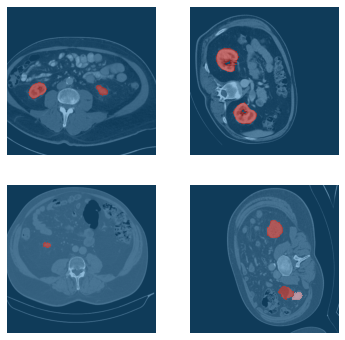

In [9]:
dls.train.show_batch()

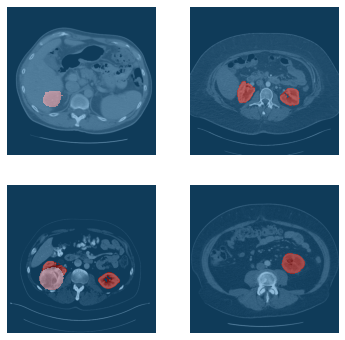

In [10]:
dls.valid.show_batch()

In [11]:
codes = np.array(["bg", "kidney", "tumor"], dtype = str)

In [12]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['bg']

In [13]:
def dice(input, target):
    input = F.softmax(input, dim=1)
    target = torch.squeeze(target,dim=1)

    eps = 0.0001
    encoded_target = input.detach() * 0
    encoded_target = encoded_target.scatter_(1, target.unsqueeze(1), 1)

    intersection = input * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)

    denominator = input + encoded_target
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = numerator / denominator

    return loss_per_channel.sum() / input.size(1)

In [14]:
class DiceLoss(nn.Module):
    """
    Dice Loss for a batch of samples
    """
    def __init__(self):
        super().__init__()

    def forward(self, output, target):
        """
        Forward pass
        :param output: NxCxHxW logits
        :param target: NxHxW LongTensor
        :return: torch.tensor
        """
        output = F.softmax(output, dim=1)
        return self._dice_loss_multichannel(output,target)

    @staticmethod
    def _dice_loss_multichannel(output, target):
        """
        Forward pass
        :param output: NxCxHxW Variable
        :param target: NxHxW LongTensor
        :param weights: C FloatTensor
        :param ignore_index: int index to ignore from loss
        :param binary: bool for binarized one chaneel(C=1) input
        :return:
        """
        target = torch.squeeze(target)
        eps = 0.0001
        encoded_target = output.detach() * 0

        encoded_target = encoded_target.scatter_(1, target.unsqueeze(1), 1)

        weights = 1

        intersection = output * encoded_target
        numerator = 2 * intersection.sum(0).sum(1).sum(1)
        denominator = output + encoded_target

        denominator = denominator.sum(0).sum(1).sum(1) + eps
        loss_per_channel = weights * (1 - (numerator / denominator))

        return loss_per_channel.sum() / output.size(1)

class CrossEntropyLoss2d(nn.Module):
    """
    Standard pytorch weighted nn.CrossEntropyLoss
    """
    def __init__(self):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        """
        Forward pass

        :param inputs: torch.tensor (NxC)
        :param targets: torch.tensor (N)
        :return: scalar
        """
        targets = torch.squeeze(targets)
        return self.nll_loss(inputs, targets)
  
class CombinedLoss(nn.Module):
    """
    A combination of dice  and cross entropy loss
    """

    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.cross_entropy_loss = CrossEntropyLoss2d()
        self.dice_loss = DiceLoss()

    def forward(self, input, target, weight=True):
        """
        Forward pass

        :param input: torch.tensor (NxCxHxW)
        :param target: torch.tensor (NxHxW)
        :param weight: torch.tensor (NxHxW)
        :return: scalar
        """
        weight = self.rtn_weight(torch.squeeze(target))

        # input_soft = F.softmax(input, dim=1)
        y_2 = torch.mean(self.dice_loss(input, target))
        if weight is True:
            y_1 = torch.mean(self.cross_entropy_loss.forward(input, target))
        else:
            y_1 = torch.mean(
                torch.mul(self.cross_entropy_loss.forward(input, target), weight))
        return y_1 + y_2

    def rtn_weight(self, labels):
        labels = labels.cpu().numpy()
        class_weights = np.zeros_like(labels)

        grads = np.gradient(labels) 
        edge_weights = (grads[0] ** 2 + grads[1] ** 2 ) > 0 
        class_weights += 2 * edge_weights
        
        return torch.from_numpy(class_weights).to(0)

In [15]:
loss_func = CombinedLoss
metrics = [dice]

In [16]:
random_seed(seed,True)
learn = unet_learner(dls, models.resnet34, loss_func = loss_func(), metrics=metrics, self_attention = True, act_cls = Mish)

In [17]:
learn.summary()

DynamicUnet (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 256 x 256  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [18]:
lr = 5e-4
learn.fit_one_cycle(30, lr)

epoch,train_loss,valid_loss,dice,time
0,0.274878,0.233603,0.768746,20:54
1,0.249351,0.236028,0.767402,20:59
2,0.247640,0.203846,0.797779,21:01
3,0.254985,0.237400,0.766252,20:55
4,0.238166,0.221920,0.780019,20:55
5,0.235227,0.199753,0.802002,20:56
6,0.203463,0.214047,0.788303,20:57
7,0.213166,0.189929,0.811575,20:57
8,0.217721,0.192158,0.809597,20:56
9,0.189868,0.179998,0.821621,20:58


In [20]:
# learn.save('./fastai_best-model_rand_e30')

Path('/home/hsyoo/brainmr/practice/body-morphometry-kidney-and-tumor/data_rand/models/fastai_best-model_rand_e30.pth')

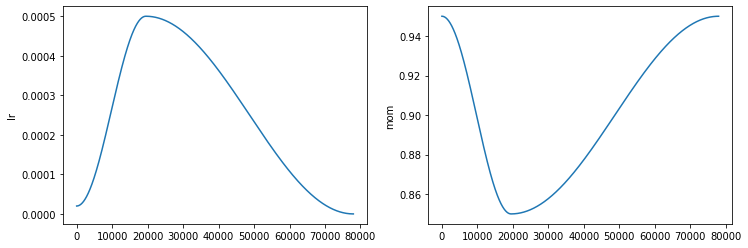

In [19]:
learn.recorder.plot_sched()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


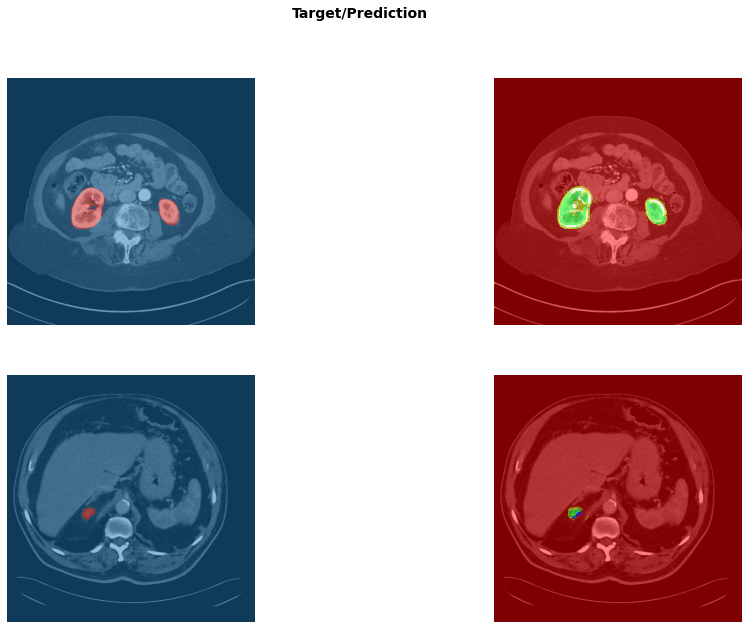

In [33]:
learn.show_results(max_n = 2, figsize=(16,10))

### Inference

In [22]:
test_images = sorted(glob.glob("./body-morphometry-kidney-and-tumor/data_rand_test/image/*.png"))

In [23]:
print(len(test_images))

5312


In [ ]:
import cv2
import albumentations as A
save_dir = "./body-morphometry-kidney-and-tumor/submissions"

valid_aug = A.Compose([
    A.Normalize()
])
for image in test_images:
    patient = image.split('/')[-1].split('_')[0]
    name = image.split('_')[-1].split('.')[0]
    inputs = np.array(Image.open(image))
#     augmented = valid_aug(image = inputs)
#     image = augmented['image']
#     print(type(image))
    a,b,c = learn.predict(inputs)
    outputs = np.argmax(c, axis = 0)
    outputs = np.array(outputs)
    outputs = outputs.astype(np.uint8)
    print(f"patient : {patient}, name : {name}, output unique : {np.unique(outputs)}")
    ipath = Path(os.path.join(save_dir, patient, f"{name}.png"))
    ipath.parent.mkdir(parents = True, exist_ok = True)
    cv2.imwrite(str(ipath), outputs)

In [42]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask,
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs


def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)


def make_submission(input_dir, save_path, num_classes):
    f = open(save_path, "w")
    f.write("Id,EncodedPixels\n")
    case_names = sorted(os.listdir(input_dir))
    for case_name in tqdm(case_names):
        case_dir = os.path.join(input_dir, case_name)
        slice_names = sorted(os.listdir(case_dir))
        for class_idx in range(1, num_classes):
            mask_stack = np.array([], dtype='uint8')
            for slice_name in slice_names:
                slice_img_path = os.path.join(case_dir, slice_name)
                slice_img = np.array(Image.open(slice_img_path).convert('L')).flatten()
                slice_mask = np.equal(slice_img, class_idx) * 255
                mask_stack = np.hstack([mask_stack, slice_mask])
            data_id = f'{case_name}_{class_idx}'
            enc = rle_to_string(rle_encode(mask_stack))
            line = f'{data_id},{enc}'
            f.write(line + "\n")
    f.close()

In [43]:
from tqdm import tqdm
submission_name = 'submission_fastai4.csv'
make_submission(input_dir=save_dir,
                    save_path=f'./submission_csv/{submission_name}',
                    num_classes=3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [06:26<00:00,  4.65s/it]
